# Star Finder and Imexam

This notebook will guide you through the steps necessary for detecting stars in your overscan subtracted, trimmed, bias subtracted, flat fielded science frames.

Doing aperture photometry requires that you be able to find stars in your image. Manually identifying the positions of stars in DS9 is not scalable to large numbers of stars or frames. Therefore, we will use the detection tools in PHOTUTILS. You can see example code and documentation here:

<a href="https://photutils.readthedocs.io/en/stable/detection.html">Star finder example code</a> <br>
<a href="https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder">DAOStarFinder documentation</a> <br>
<a href="https://imexam.readthedocs.io/en/0.9.1/">imexam</a> <br>
<a href="https://imexam.readthedocs.io/en/latest/api/imexam.imexamine.Imexamine.html#imexam.imexamine.Imexamine.radial_profile">imexam radial profiles</a> <br>
<a href="https://github.com/spacetelescope/imexam">imexam repo with some example notebooks</a> <br>

In [2]:
# import block
# some of these may not be needed
import numpy as np
from astropy.io import fits
import pdb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib
from astropy.visualization import hist
from datetime import datetime
from pathlib import Path
import os
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D, Gaussian1D,Gaussian2D,Polynomial2D
from astropy.modeling import fitting
from astropy.stats import mad_std
from astropy.nddata import CCDData, StdDevUncertainty
from scipy import stats
from astropy import units as u
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.table import Table
from astropy.coordinates import SkyCoord

In [3]:
# grab show_image
phot_tutorial_dir = '/home/kyle/Homework/Astro8060/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [4]:
# plotting defaults
# Use custom style for larger fonts and figures
plt.style.use(phot_tutorial_dir+'/guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=12)
rc('axes', grid=True)

In [5]:
# define directories
reduced_dir = '/mnt/chromeos/removable/ChromeSD/NoBackupImages/reduced/bias&trim/' # working directory

## 1. Find bright stars in the middle of your frame

The star finder implemented in PHOTUTILS is an implementation of <a href="https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract">DAOPHOT</a>. Generally speaking, it looks for peaks in the distribution of pixel values in a frame. The challenges are to detect real stellar peaks near the level of the background and/or noise in the image, and to distinguish stellar peaks from various kinds of noise spikes and other astronomical sources (e.g., galaxies).


<b>Look at the documentation and DAOPHOT paper to answer the following:</b>
 - How do you control how faint the stars you find are? <br>
 
Threshold parameter (the absolute value of the pixel)
 - How do you avoid saturated stars?<br>
 
Peakmax parameter (the maximum allowed value to be counted as a star)
 - What is sharpness?<br>
 
The comparison between how bright the central pixel values are to the off center pixel values (deltas are sharp, gaussians are not)
 - What is roundness?<br>
 
The symmetry of its x and y gaussian functions

<b>Read in the data and plot the image</b>

Plot the central part of the frame for columns 750-1250 and rows 1000-1500 for a085otzf.fits.

In [15]:
# read in the data
img = fits.open(reduced_dir+'a085ot.fits')[0].data

In [16]:
# set the column and row range of interest
row_lo = 1000
row_hi = 1500
col_lo = 750
col_hi = 1250

/tmp/ipykernel_4163/858099078.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks()+col_lo)
/tmp/ipykernel_4163/858099078.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks()+row_lo)


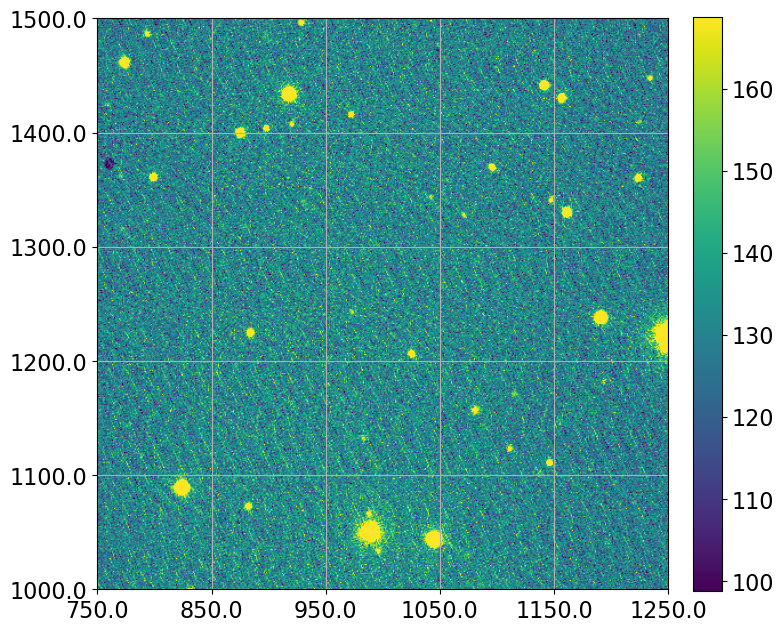

In [17]:
# plot only the center of the frame from col_lo to col_hi and row_lo to row_hi
# the tricky part here is to make sure the axis labels have the right values
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show_image(img[row_lo:row_hi,col_lo:col_hi],fig=fig,ax=ax)
# add code to plot here
ax.set_xticklabels(ax.get_xticks()+col_lo)
ax.set_yticklabels(ax.get_yticks()+row_lo)
plt.tight_layout()
plt.show()

<b> Find the bright stars </b>
Look at the Star Finder example code to see the syntax for this. You will need a guess for fwhm (we'll measure this next). Approximately how many pixels would be reasonable starting guess? (The size of a faint start might be a good starting place.)

In [35]:
# write code based on the example notebook
# the line below is just to show you what the "sources" variable should be for later cells
mean, median, std = sigma_clipped_stats(img,sigma=3)

daofind = DAOStarFinder(fwhm=3.0, threshold=5.0*std, peakmax=0.8*(2**16))
sources = daofind(img[row_lo:row_hi,col_lo:col_hi])
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,1.6725156083196546,1.68228645960335,0.5867206826482051,0.4349894973983148,0.4688155943267084,25,0.0,126.73340901103927,1.0720089600198188,-0.07549603818409589
2,497.58282767900397,1.4806375726584227,0.8688327114196525,0.11243911486338527,0.3598189192661886,25,0.0,157.73340901103927,1.2382302912778822,-0.23200356027669453
3,294.77388016862966,43.19995671718802,0.4605860079646198,-0.06756770792967674,0.13908952231970811,25,0.0,7457.743418659714,72.09620747844109,-4.644781049645115
4,238.84013661652833,49.27291250885895,0.4570464576280313,-0.020496642714621663,0.17759329893508338,25,0.0,17415.74469190163,173.5279812739887,-5.5984237861901
5,132.12822902406614,72.02406830424418,0.44791385925707444,-0.10440910537547815,0.1972236587579447,25,0.0,292.7492280989479,1.865607701192199,-0.6770508146044251
6,73.80394979097026,88.2211141515778,0.45533849943105625,0.013901609255614119,0.1597661329160599,25,0.0,5619.752072255402,56.717768603681904,-4.384297841131702
7,395.4921079387536,110.11830550914267,0.4276130228737287,-0.11812126406159361,0.1777189926455411,25,0.0,286.7555854744272,1.585647365172123,-0.5005165255687747
8,274.9863910928727,205.37034220961664,0.45174131169880094,0.15121571360176952,0.2045699147868846,25,0.0,347.76604466995866,2.3845449952696343,-0.9435138044618776
9,134.00641311996395,224.03215963239157,0.48786015072563,-0.04320622087069588,0.17373933773754904,25,0.0,417.76733261973686,2.9454229529561005,-1.1728691671167555


<b> Plot the image again and mark the detected stars </b>

Making apertures at the position of the stars you detect would be a good method for showing where they are.

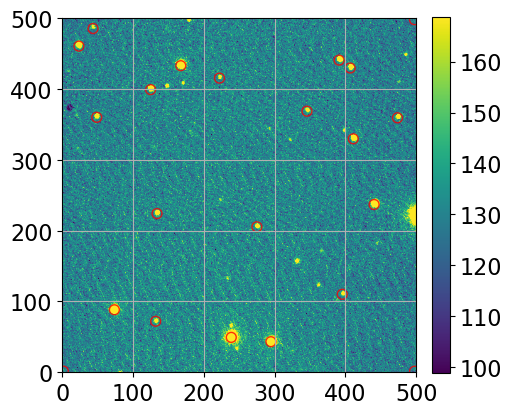

In [36]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
show_image(img[row_lo:row_hi,col_lo:col_hi],fig=fig,ax=ax)
positions = [(x,y) for x,y in zip(sources['xcentroid'],sources['ycentroid'])] # this syntax is handy for apertures
aps = CircularAperture(positions,r=7.0)
aps.plot(color='red',lw=1,alpha=0.8)
plt.show()

## 2. Measure the PSF FWHM

The point spread function (PSF) full width at half maximum (FWHM) is a measure of the width in pixels where light from a point source is distributed on the CCD. Many of the detection methods above take the PSF FWHM as an input to help distinguish from noise spikes. Also, you may want to explore the PFS as a function of time or position on the CCD. Thus, it is worthwhile to know how to measure it.

A simple estimate for the PSF FWHM would find the 1D Gaussian distribution of light from a single star in a column or row and determine its width. More complex algorithms include centroiding, 2D model fitting, and background subtraction. The imexam package includes these and many more tools. 

(Imexam also has many interactive tools and can run with DS9, but it is finicky to get the display set up. See the accompanying notebook if you are feeling extremely bold.)


We will use imexam to create a radial profile plot. This shows the azimuthally averaged value of the counts in a frame as a function of radius from the star centroid. The FWHM is taken from the width of this (Gaussian) profile.

A warning about the radial profiles in imexam: they can fail with various errors if the position is near the edge of the frame.

<b>Calculate the FWHM for the sources you found in the previous step.</b>

In [37]:
!pip install imexam

     |████████████████████████████████| 21.4 MB 148 kB/s eta 0:00:01.7 MB 2.9 MB/s eta 0:00:07     |████████▏                       | 5.4 MB 2.9 MB/s eta 0:00:06     |████████████▏                   | 8.1 MB 2.9 MB/s eta 0:00:05/s eta 0:00:04MB/s eta 0:00:03��███████████████   | 19.4 MB 2.9 MB/s eta 0:00:01
  Created wheel for imexam: filename=imexam-0.9.1-cp39-cp39-linux_x86_64.whl size=136581 sha256=63f045af3f49329ee289f7973f2f5f1cceef702aefbb511d39728512604db489
  Stored in directory: /home/kyle/.cache/pip/wheels/55/d8/5a/7812c67734fe154e6b588adc2951b1d6c479c7700cbd5bc60c
Successfully built imexam


In [40]:
from imexam.imexamine import Imexamine

#initalize the object to get access to the plotting functions
plots=Imexamine() 

Ginga not installed, use other viewer, or no viewer


(440.47975870288883, 236.87532693562076)

xc=1325.9585	yc=1054.5044
Background per pixel: 127.88095731033958
Max. pix. flux =   215.865
amp =   218.768
fwhm =     3.659


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


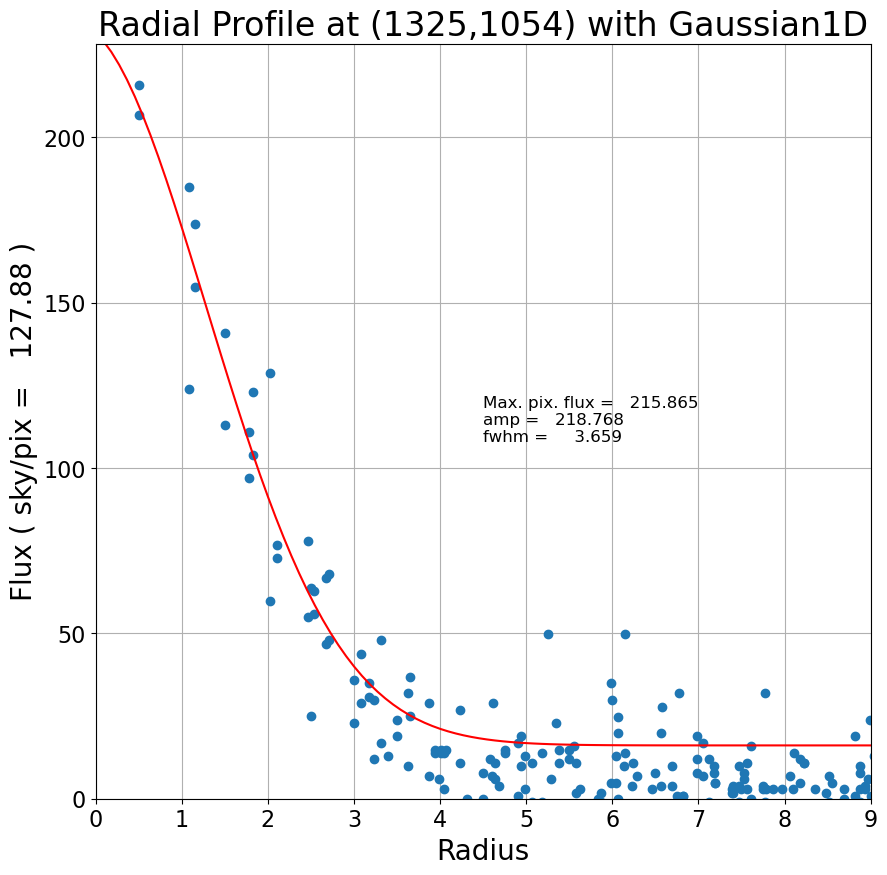

Uhoh
Uhoh
xc=294.8030	yc=43.2158
Background per pixel: 139.71850646299652
Max. pix. flux =  7318.025
amp =  7931.205
fwhm =     4.160


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


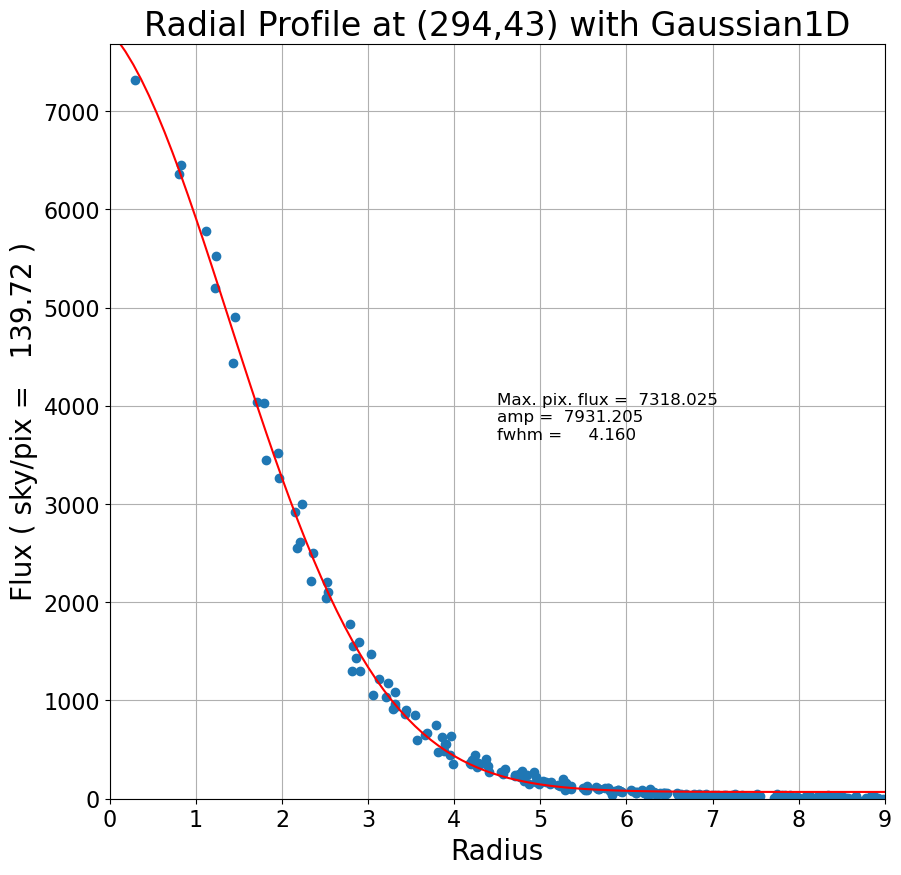

xc=238.8684	yc=49.2803
Background per pixel: 149.91260753434523
Max. pix. flux = 17265.832
amp = 19267.475
fwhm =     4.287


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


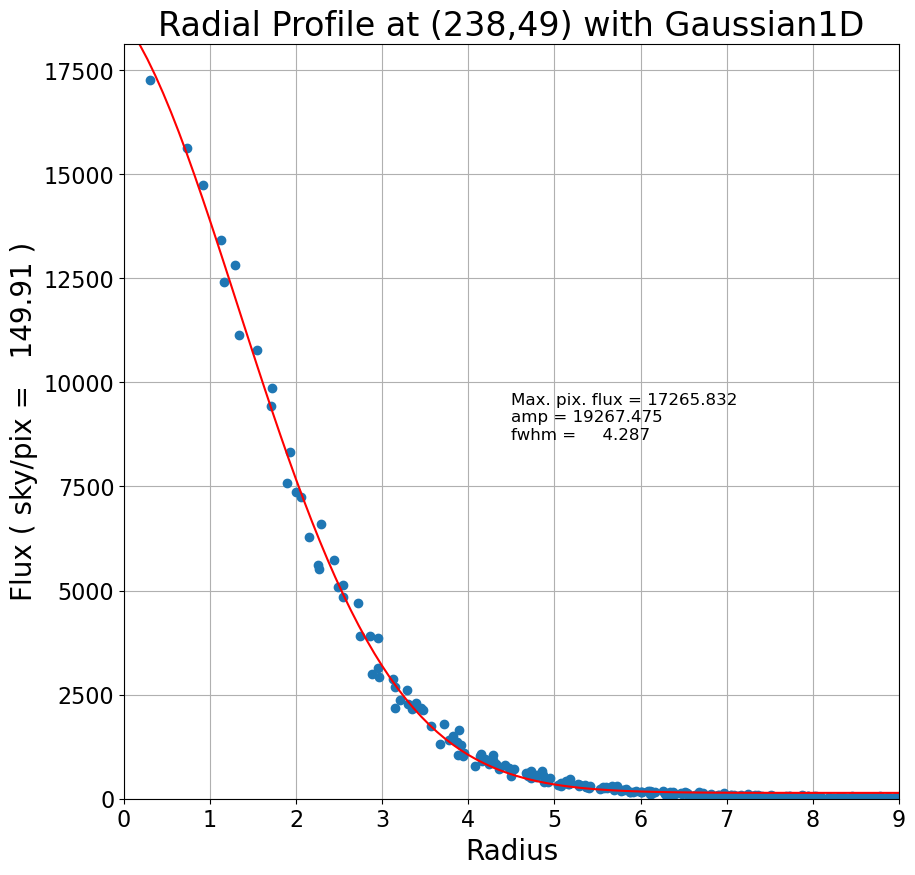

xc=132.1747	yc=71.9265
Background per pixel: 132.5910777667136
Max. pix. flux =   160.158
amp =   156.766
fwhm =     3.719


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


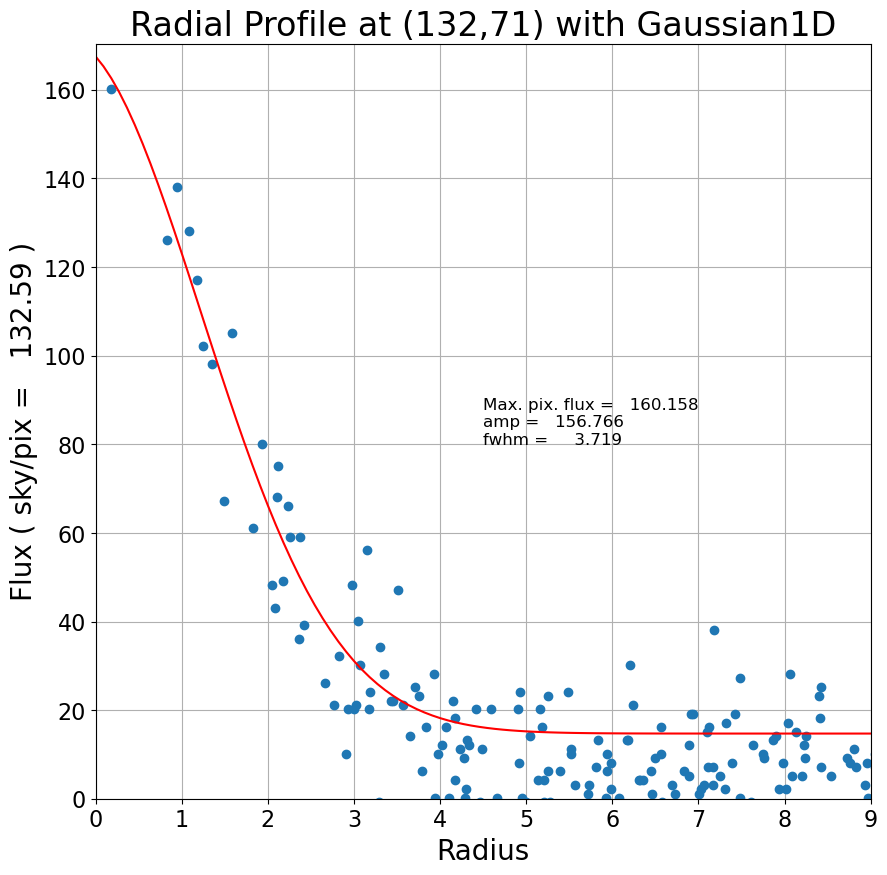

xc=73.8344	yc=88.2288
Background per pixel: 135.1311770303127
Max. pix. flux =  5484.621
amp =  6004.682
fwhm =     4.109


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


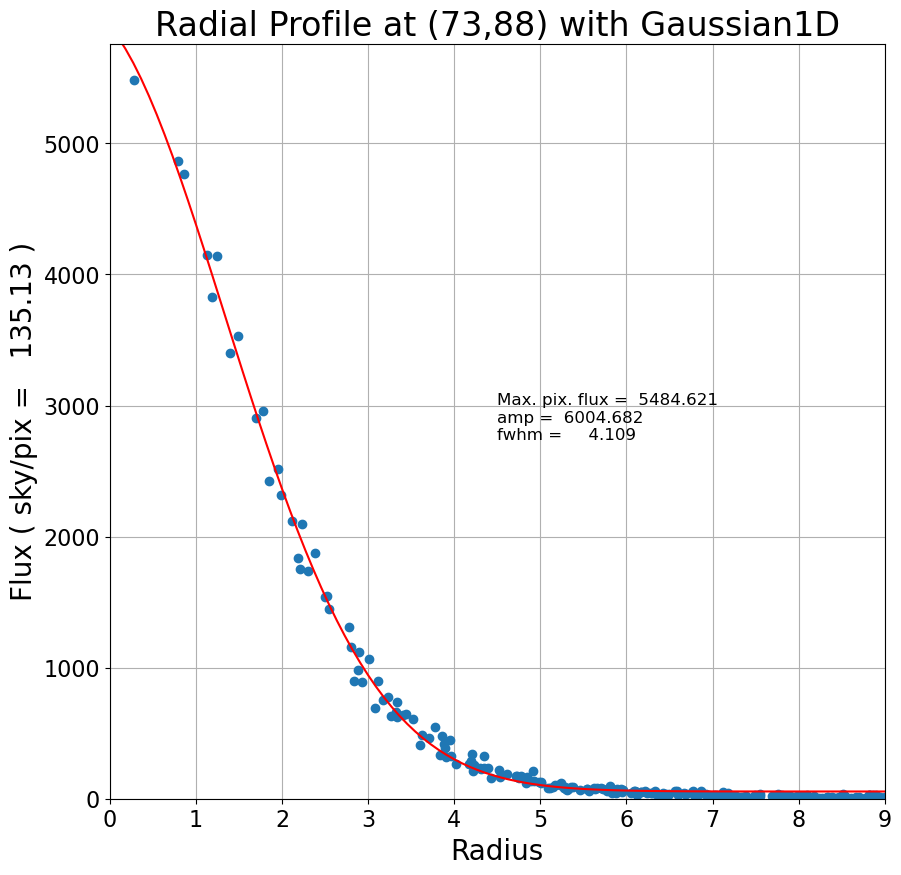

xc=395.6397	yc=110.2160
Background per pixel: 131.80230218859796
Max. pix. flux =   154.953
amp =   141.876
fwhm =     3.279


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


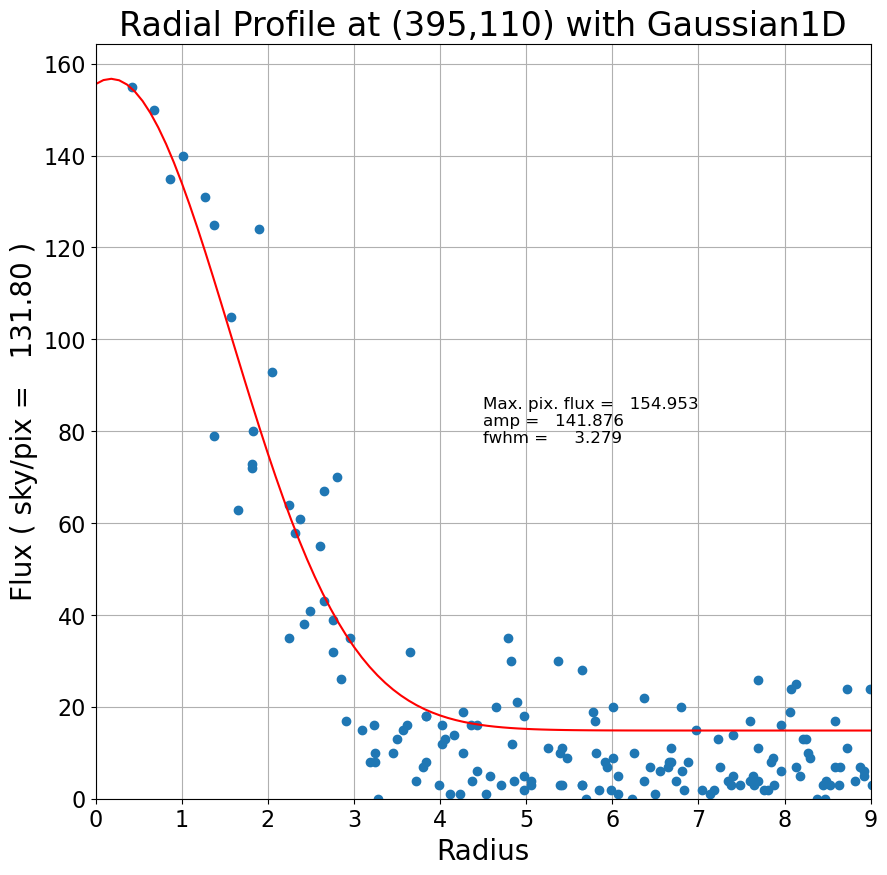

xc=274.9461	yc=205.3644
Background per pixel: 132.78381284417918
Max. pix. flux =   220.982
amp =   251.031
fwhm =     4.179


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


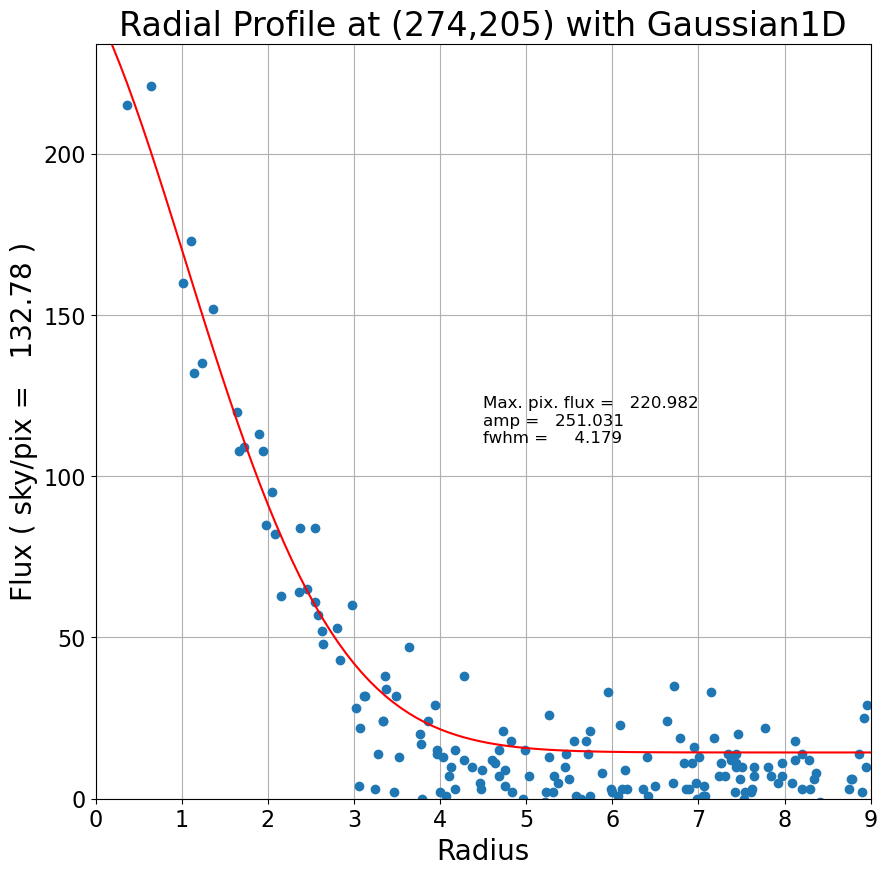

xc=133.9922	yc=224.0303
Background per pixel: 133.04226229327963
Max. pix. flux =   284.725
amp =   275.196
fwhm =     3.768


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


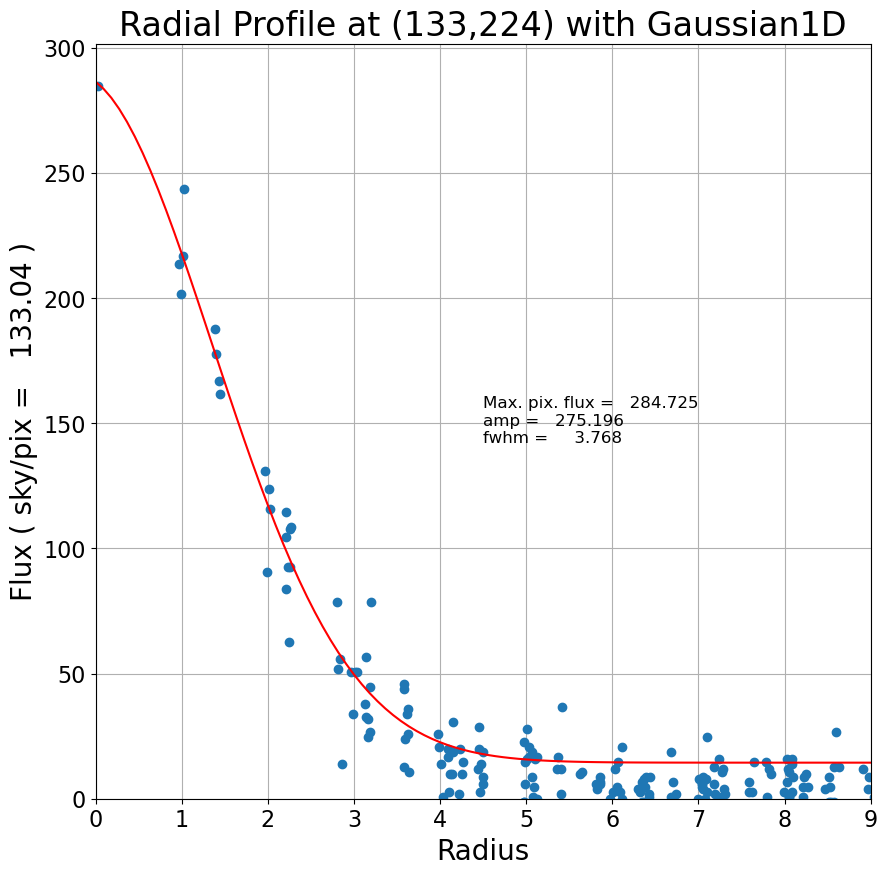

xc=440.4397	yc=236.8841
Background per pixel: 132.18954312232697
Max. pix. flux =  2741.579
amp =  3067.285
fwhm =     4.046


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


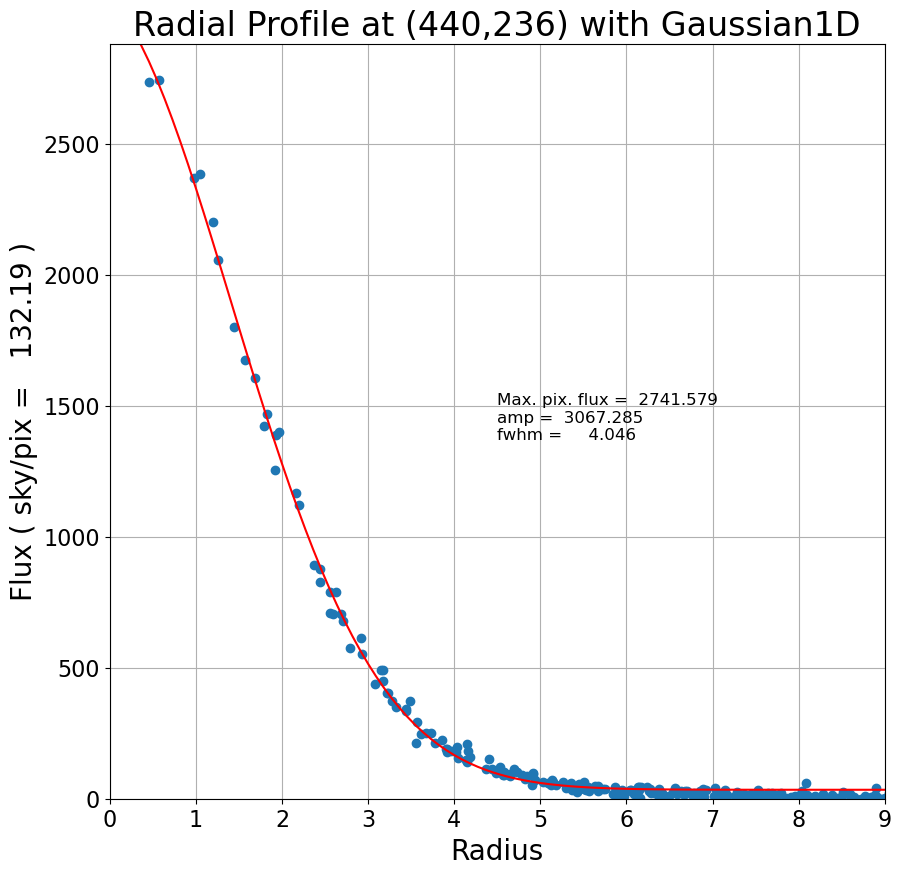

xc=411.0130	yc=329.5535
Background per pixel: 132.7252616455866
Max. pix. flux =   788.045
amp =   802.851
fwhm =     3.797


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


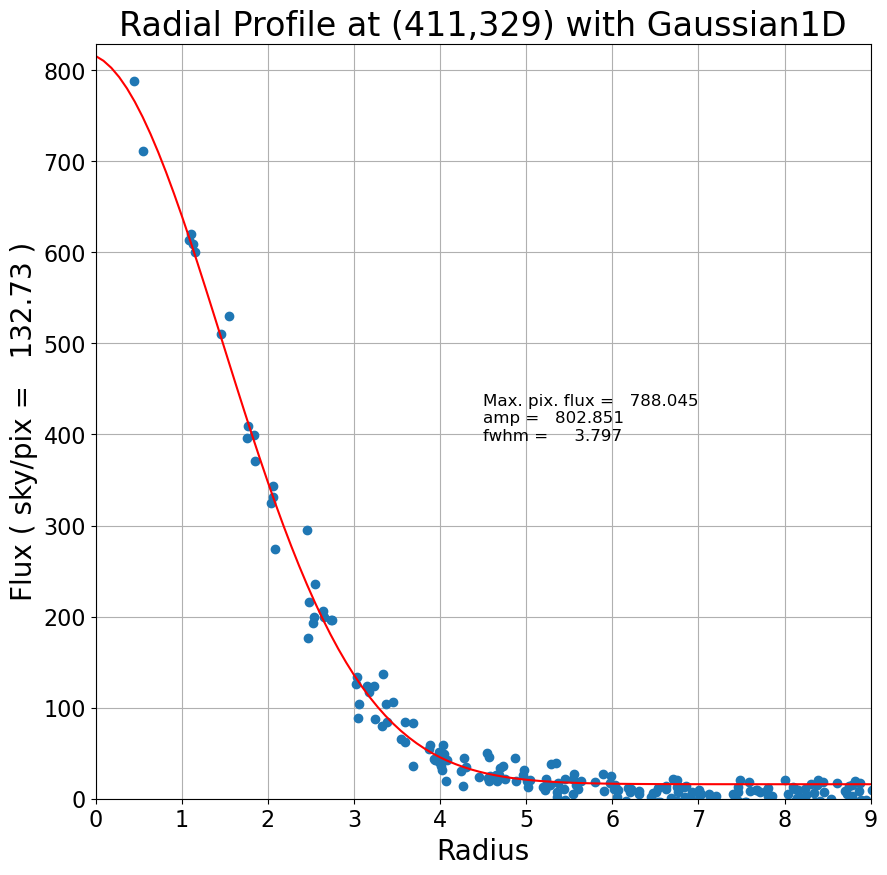

xc=473.4883	yc=359.3204
Background per pixel: 128.43491941163984
Max. pix. flux =   285.336
amp =   264.111
fwhm =     3.190


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


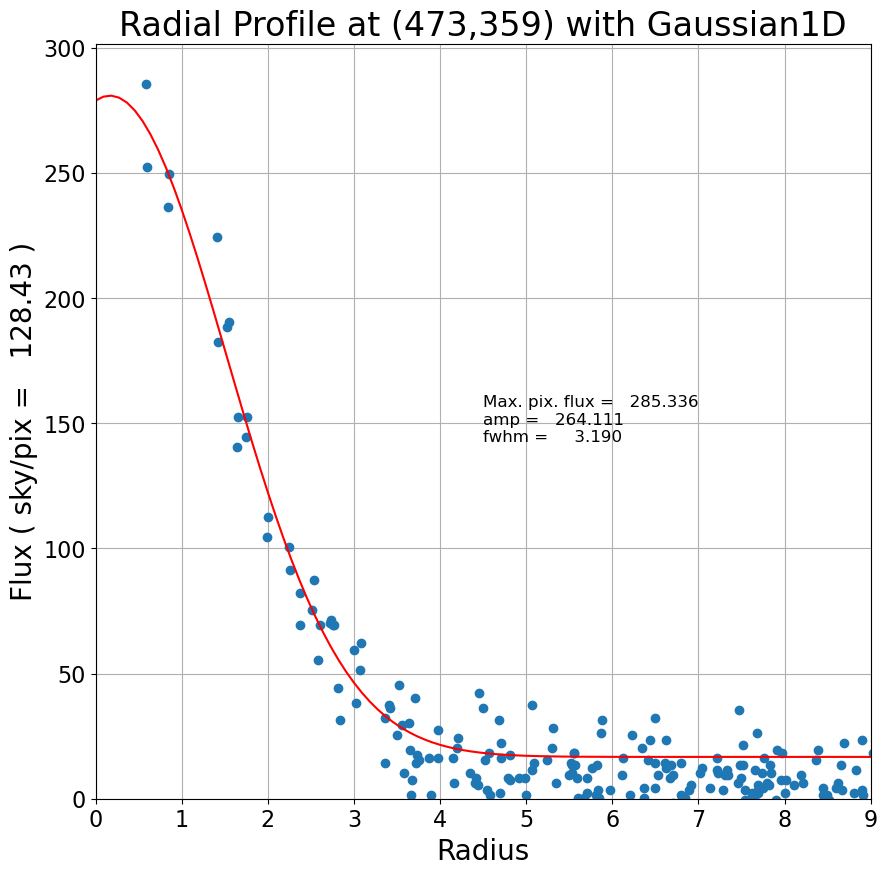

xc=48.9159	yc=360.0256
Background per pixel: 130.08578716941466
Max. pix. flux =   310.685
amp =   303.111
fwhm =     3.487


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


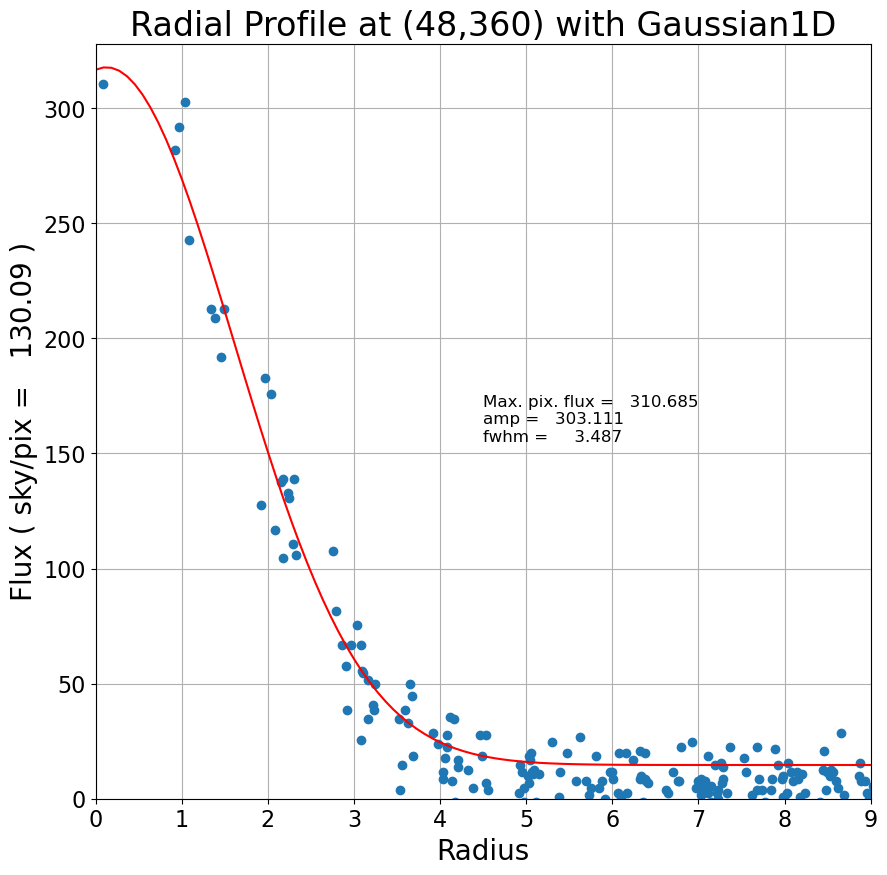

xc=345.5628	yc=368.5737
Background per pixel: 131.38915984638433
Max. pix. flux =   135.382
amp =   121.442
fwhm =     3.525


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


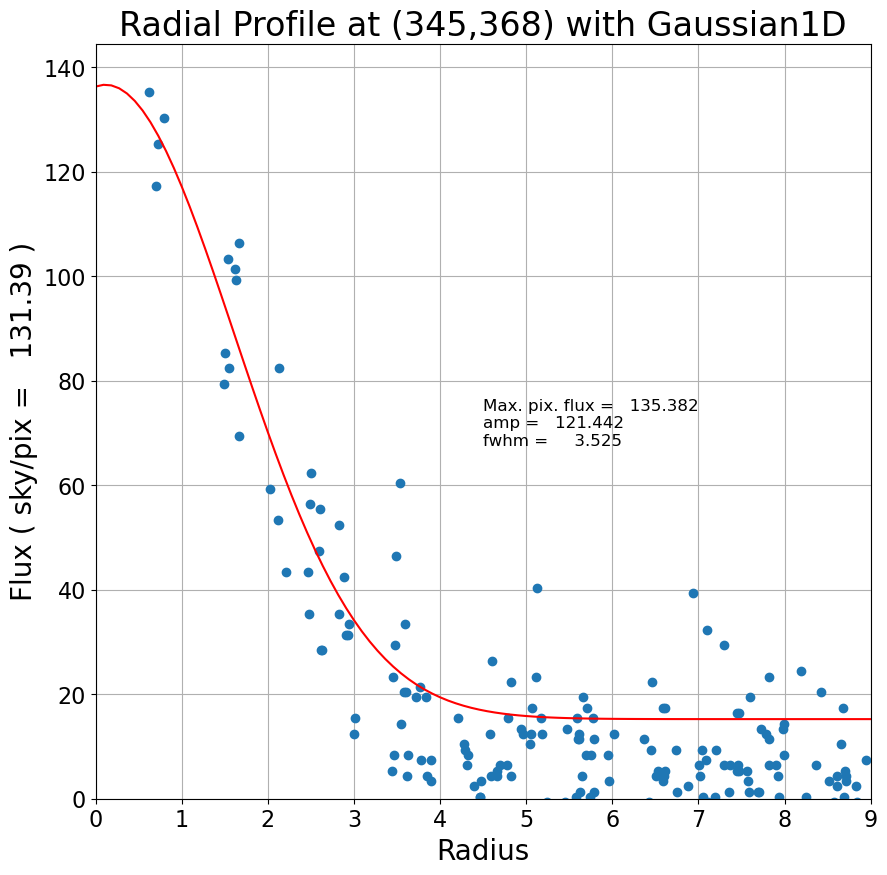

xc=124.9711	yc=399.0835
Background per pixel: 131.13954585644814
Max. pix. flux =   611.631
amp =   605.263
fwhm =     3.550


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


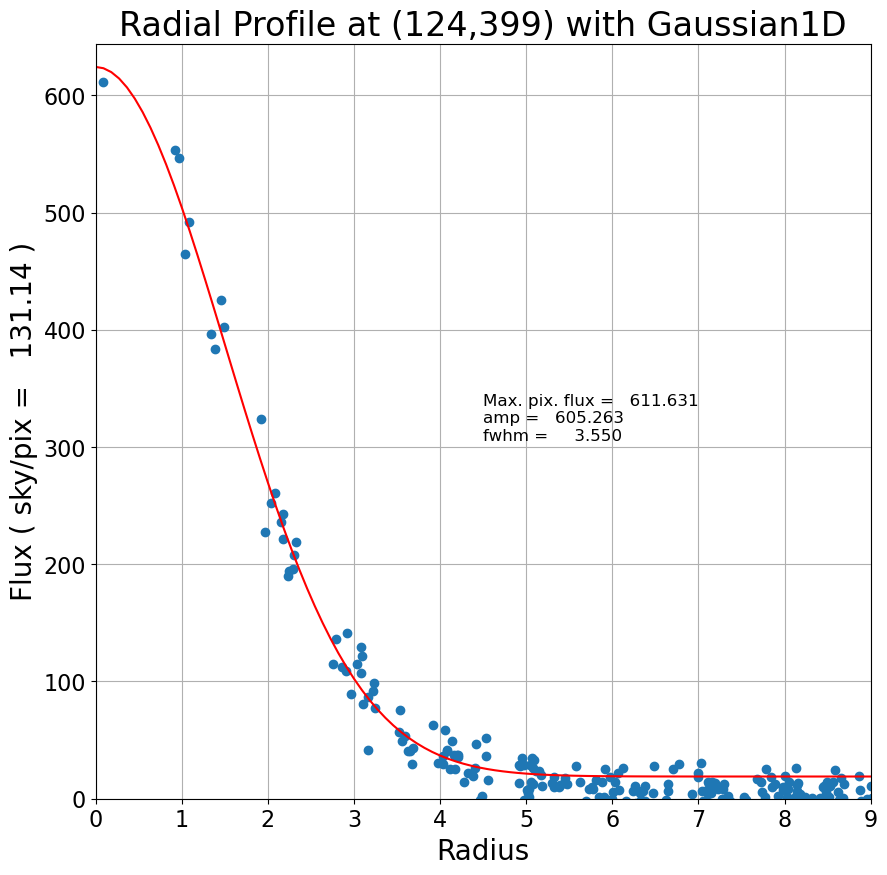

xc=222.1165	yc=415.1891
Background per pixel: 131.77663557941477
Max. pix. flux =   117.993
amp =    97.047
fwhm =     3.363


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


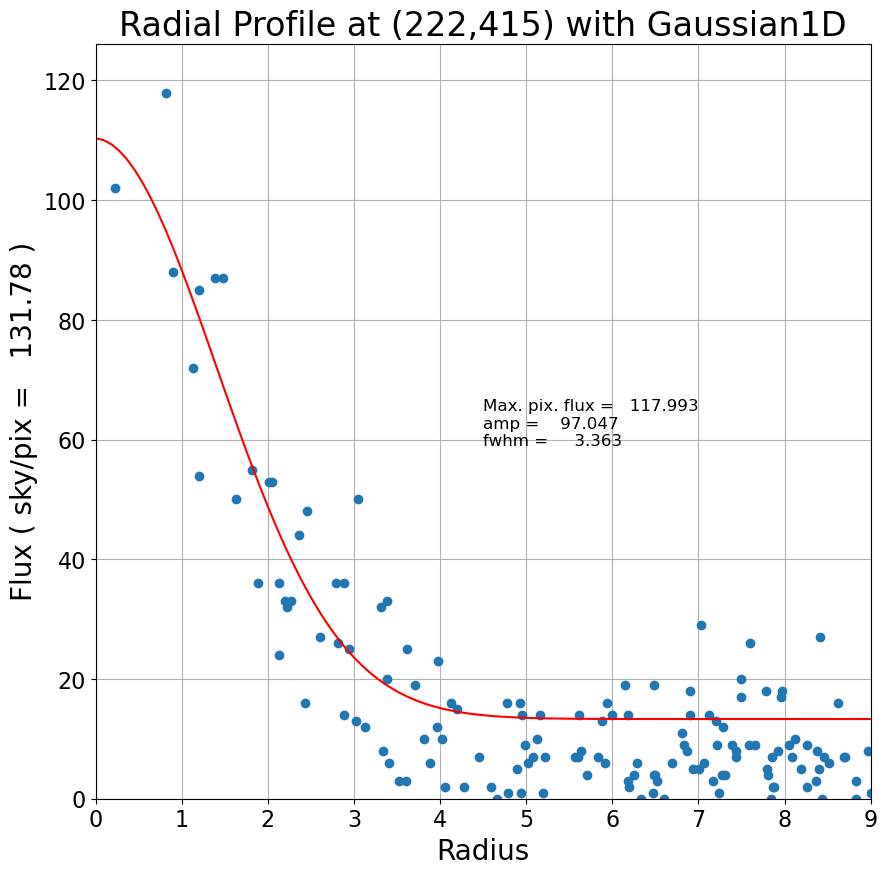

xc=406.7148	yc=429.4925
Background per pixel: 130.77169311595608
Max. pix. flux =   486.998
amp =   525.708
fwhm =     3.794


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


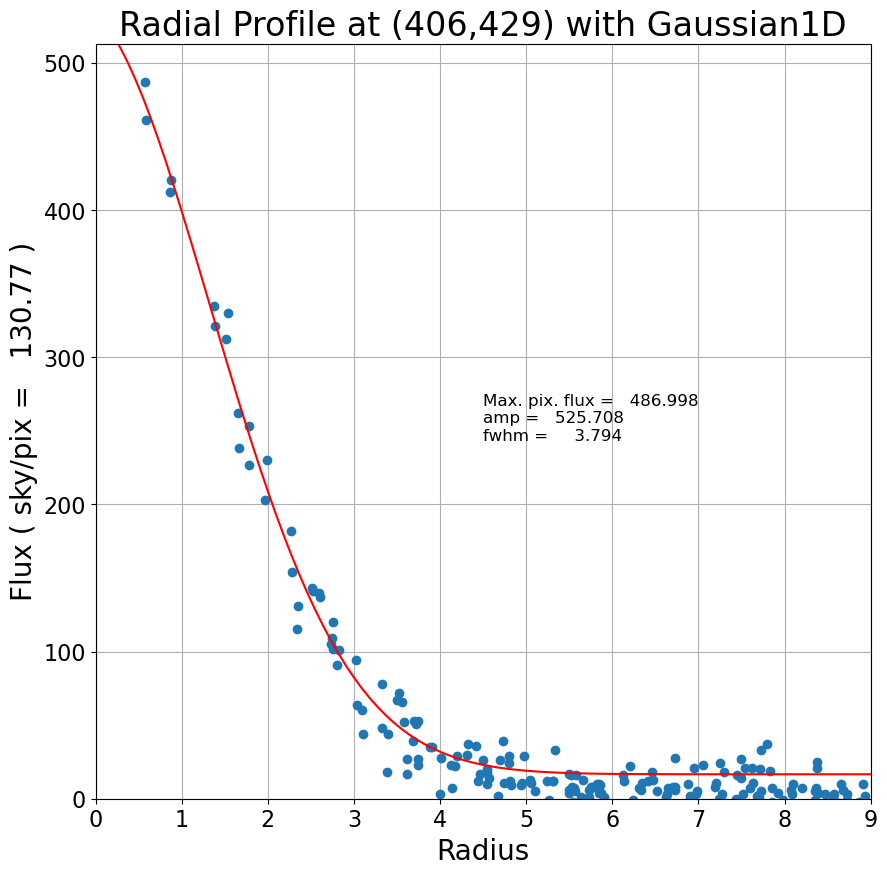

xc=167.5440	yc=432.8161
Background per pixel: 135.5272513826019
Max. pix. flux =  4562.243
amp =  5421.211
fwhm =     4.213


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


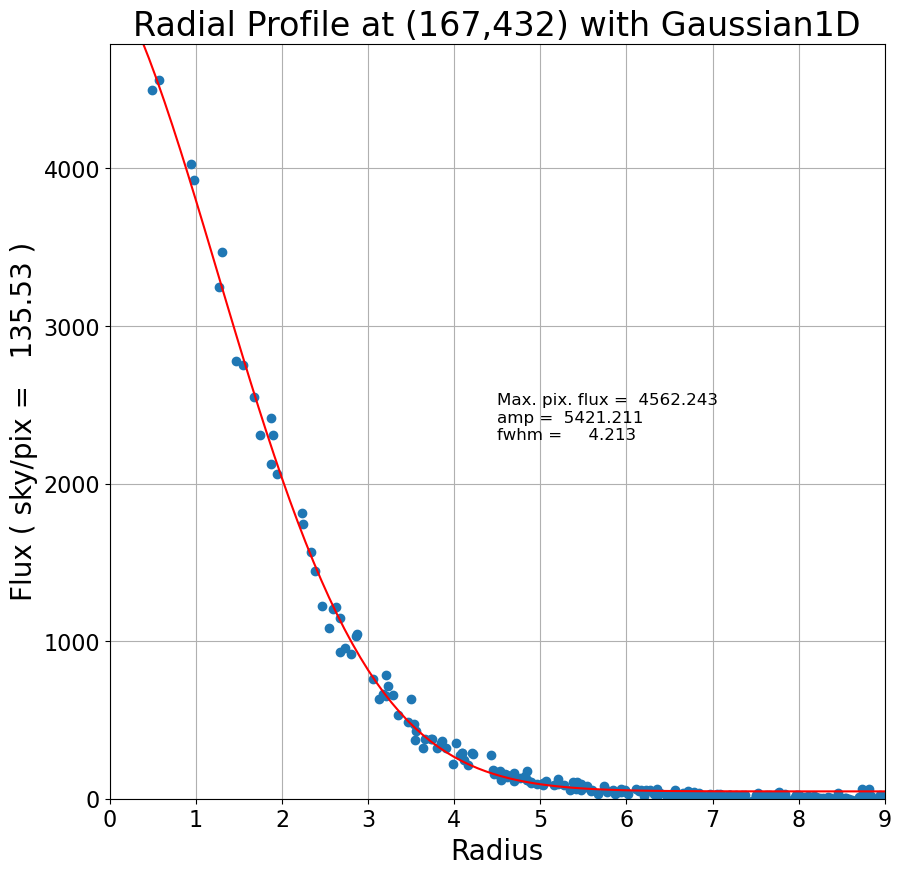

xc=391.0693	yc=440.6982
Background per pixel: 132.13605688479726
Max. pix. flux =   762.634
amp =   818.484
fwhm =     3.857


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


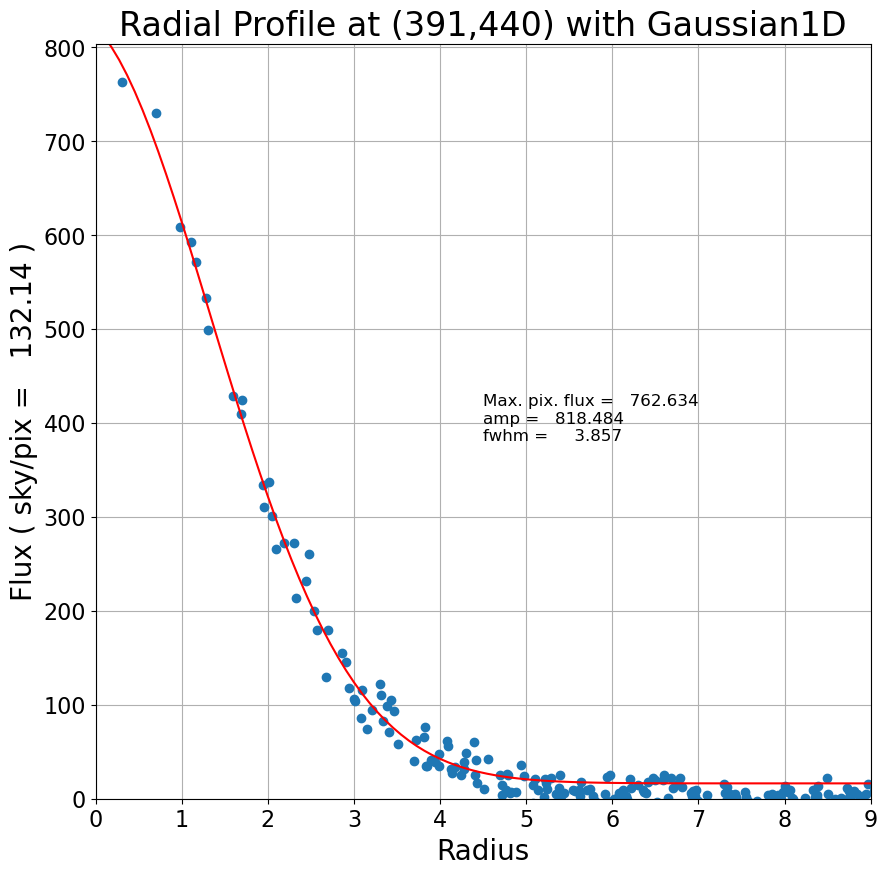

xc=23.7092	yc=460.5119
Background per pixel: 129.58350421414005
Max. pix. flux =  1083.186
amp =  1224.344
fwhm =     4.030


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


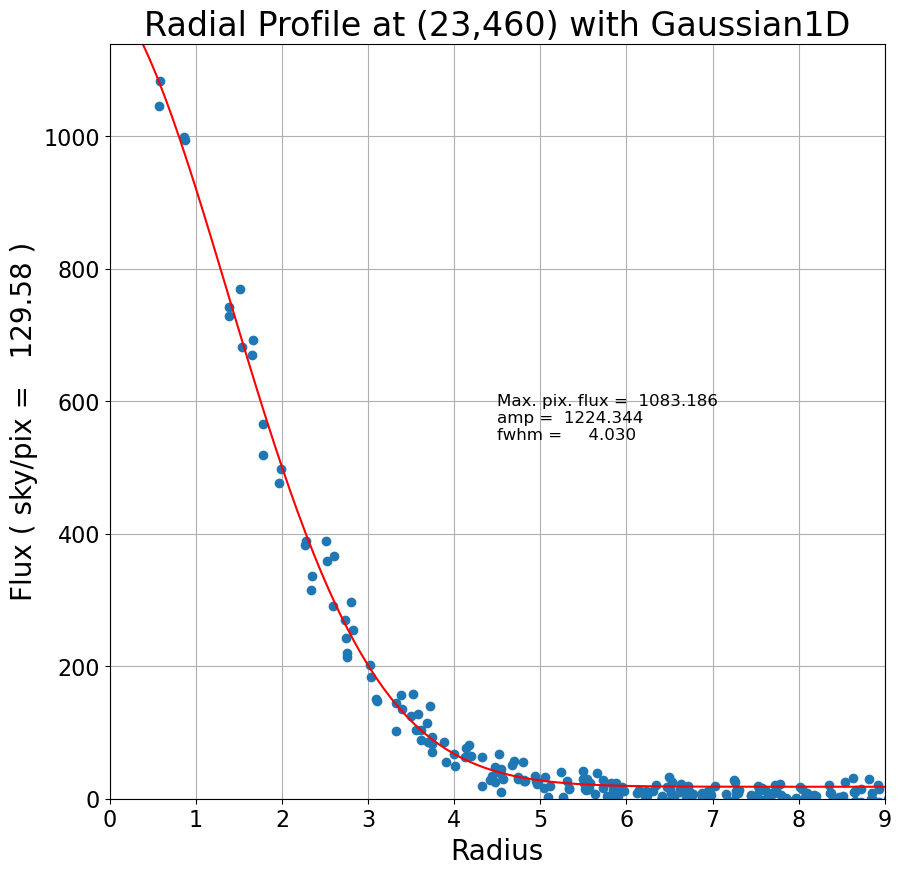

xc=43.5506	yc=485.6073
Background per pixel: 125.35658611738977
Max. pix. flux =   109.412
amp =    88.594
fwhm =     3.719


/home/kyle/anaconda3/envs/astro8060/lib/python3.9/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


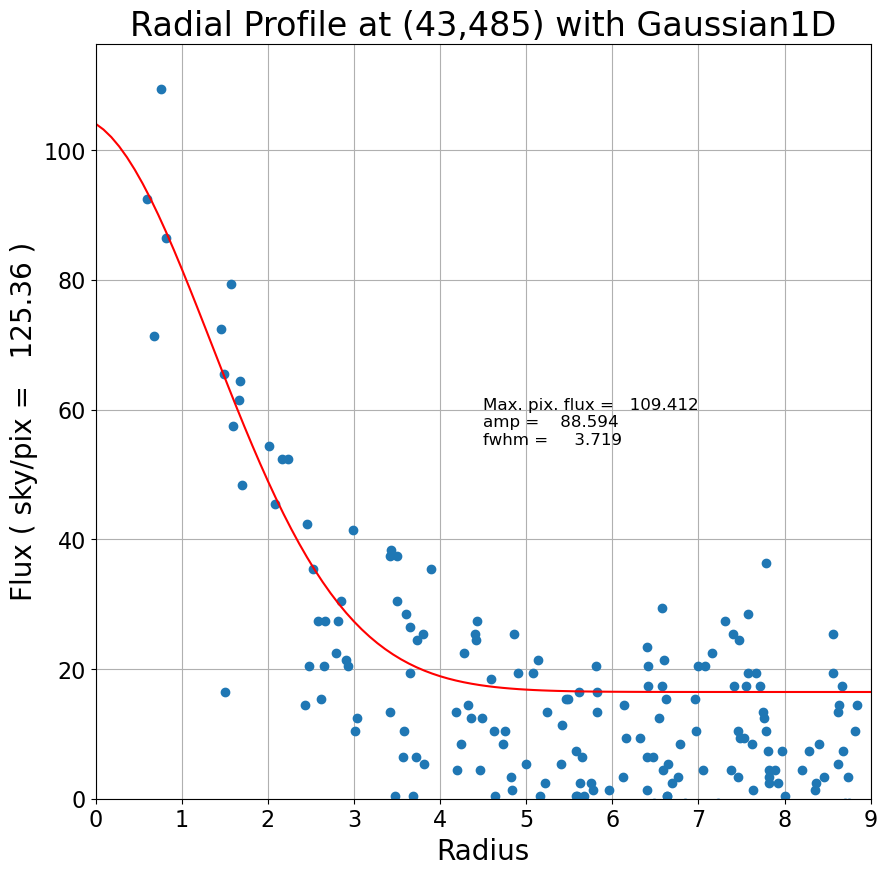

xc=494.9444	yc=496.9172
Background per pixel: 43.31966961028517
Max. pix. flux =   121.449
amp =     6.064
fwhm =     9.796


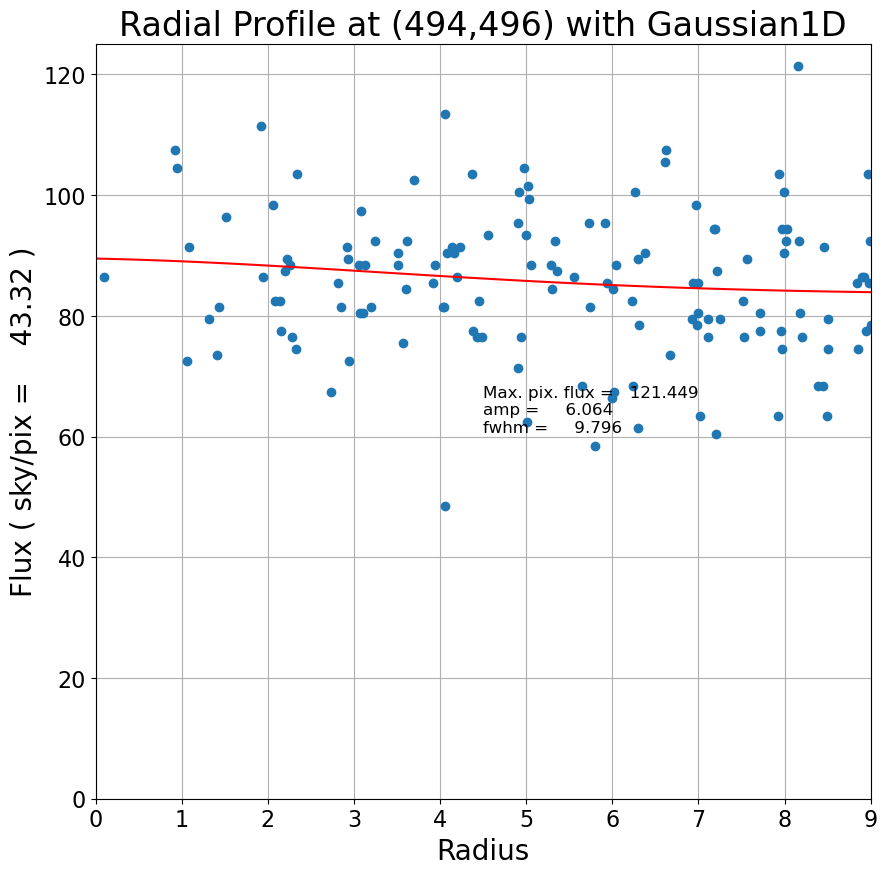

In [61]:
# here is one radial profile at 1325,1054
#plots.radial_profile(positions[9][0],positions[9][1],img,genplot=True)
plots.radial_profile(1325,1054,img,genplot=True)

# loop over the x and y centroids from the star finder
# and generate a radial profile for each one
# how much does the FWHM vary between these?
for x,y in zip(sources['xcentroid'],sources['ycentroid']):
    #print(x,y) # dummy loop, add code here to do radial profiles
    try:
        plots.radial_profile(x,y,img[row_lo:row_hi,col_lo:col_hi],genplot=True)
    except:
        print("Uhoh")

## 3. Write a function to do aperture photometry

Write a function that takes a filename and:

1. Reads in the data.
2. Finds all the sources in the image.
3. Puts a circular aperture and background annulus on each of the stars.
4. Calculates background-subtracted instrumental magnitudes.
5. Plots the image and apertures for visual inspection.
6. Returns a table of photometry, including the instrumental magnitudes.

Run your function on a085otzf.fits.

In [157]:
def get_phot(filename):
    # do photometry
    phot = 0
    return phot

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10


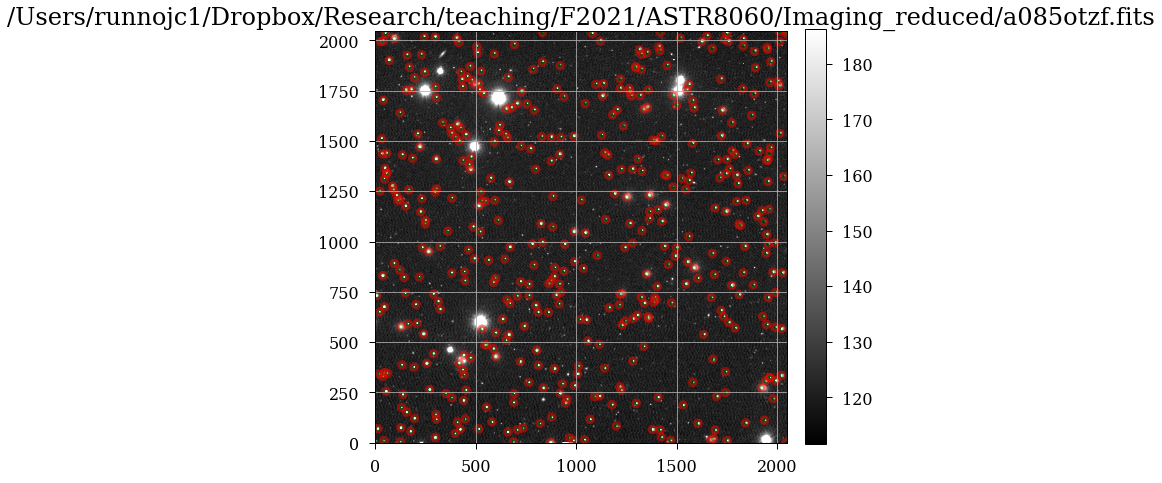

id,xcenter,ycenter,aperture_sum,inst_mag
,pix,pix,,
int64,float64,float64,float64,float64
1,873.54204,0.85529202,489178.74,-14.17373
2,2045.548,1.4169481,14635.458,-8.9160031
3,688.00279,3.9507222,32858.069,-10.044549
4,127.82611,5.6236807,35715.755,-10.214331
5,44.554311,11.158886,40864.091,-10.294757
6,984.73065,12.322523,45557.729,-9.4894149
7,1468.4608,12.246134,43594.726,-10.303692
8,1749.025,11.883831,53721.535,-10.978235


In [196]:
phot = get_phot(reduced_dir+'a085otzf.fits')
phot